# **Import Libraries**

In [ ]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from nltk import FreqDist
from math import log10
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
pd.set_option('display.max_colwidth', None)

# **Download GolVe**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2020-08-17 11:28:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-17 11:28:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-17 11:28:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
f = open("glove.6B.300d.txt", "r")
text = f.read()
f.close()
word_vectors = text.split("\n")
words = []
vectors = []
for vector in word_vectors:
  comps = vector.split(" ")
  words.append(comps[0])
  vectors.append([float(i) for i in comps[1:]])
words = words[:-1]
vectors = vectors[:-1]
df_vectors = pd.DataFrame(vectors, index=words)
df_vectors

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
the,0.046560,0.213180,-0.007436,-0.458540,-0.035639,0.236430,-0.288360,0.215210,-0.134860,-1.641300,-0.260910,0.032434,0.056621,-0.043296,-0.021672,0.224760,-0.075129,-0.067018,-0.142470,0.038825,-0.189510,0.299770,0.393050,0.178870,-0.173430,-0.211780,0.236170,-0.063681,-0.423180,-0.116610,0.093754,0.172960,-0.330730,0.491120,-0.689950,-0.092462,0.247420,-0.179910,0.097908,0.083118,...,-0.287970,-0.058996,-0.032436,-0.004701,-0.170520,-0.034741,-0.114890,0.075093,0.099526,0.048183,-0.073775,-0.418170,0.004127,0.444140,-0.160620,0.142940,-2.262800,-0.027347,0.813110,0.774170,-0.256390,-0.115760,-0.119820,-0.213630,0.028429,0.272610,0.031026,0.096782,0.006777,0.140820,-0.013064,-0.296860,-0.079913,0.195000,0.031549,0.285060,-0.087461,0.009061,-0.209890,0.053913
",",-0.255390,-0.257230,0.131690,-0.042688,0.218170,-0.022702,-0.178540,0.107560,0.058936,-1.385400,0.585090,0.036501,-0.198460,0.196130,0.409290,0.157020,-0.153050,0.050447,0.300450,-0.112950,-0.017043,0.185930,0.199820,0.200530,-0.631410,-0.126220,0.295100,-0.262820,-0.158310,0.001238,0.011784,0.587580,-0.159140,0.277310,-0.823430,-0.211340,0.013414,0.196370,-0.414700,0.001028,...,-0.063187,-0.245530,-0.059751,0.068787,-0.116270,-0.008340,0.005204,-0.201590,-0.023663,0.175620,-0.314750,-0.111620,-0.124920,0.109490,-0.269130,0.348930,-1.699700,-0.244700,0.302920,0.056720,-0.317370,0.083612,0.095949,-0.175900,0.102350,0.368080,-0.343800,0.206070,0.191350,0.109920,0.075968,-0.014359,-0.073794,0.221760,0.146520,0.566860,0.053307,-0.232900,-0.122260,0.354990
.,-0.125590,0.013630,0.103060,-0.101230,0.098128,0.136270,-0.107210,0.236970,0.328700,-1.678500,0.223930,0.124090,-0.086708,0.330100,0.343750,-0.000876,-0.296580,0.244170,-0.115920,-0.035742,-0.010830,0.207760,0.292850,-0.073491,-0.185980,-0.200900,-0.095366,0.006373,-0.136200,0.092028,-0.039957,0.190270,-0.104560,0.002767,-0.717420,-0.129150,-0.001345,0.270020,-0.053023,0.221480,...,-0.136670,-0.439620,0.237040,0.031296,0.074701,-0.223870,0.007816,-0.190160,0.044444,0.201910,-0.208140,-0.283820,0.104270,-0.210980,0.188650,0.316590,-2.075300,-0.071045,0.524190,0.056023,-0.252950,-0.062168,-0.109890,-0.357550,-0.079244,0.374720,-0.283530,0.163370,0.111650,-0.098002,0.060148,-0.156190,-0.119490,0.234450,0.081367,0.246180,-0.152420,-0.342240,-0.022394,0.136840
of,-0.076947,-0.021211,0.212710,-0.722320,-0.139880,-0.122340,-0.175210,0.121370,-0.070866,-1.572100,-0.224640,0.042690,-0.401800,0.210060,0.014288,0.416280,0.017165,0.071732,0.006925,0.181070,-0.154120,0.149330,-0.030493,0.299180,0.029479,-0.036147,-0.061125,0.083918,-0.123980,-0.100770,-0.005414,0.337100,-0.256120,0.443880,-0.689220,0.180200,0.348980,-0.052284,-0.262260,-0.471090,...,0.467280,0.482140,0.105480,0.065805,0.067221,0.133210,-0.278560,0.015532,0.300260,0.387480,-0.144010,-0.161310,0.176780,0.164480,-0.324400,0.007937,-2.283600,0.096945,0.661310,0.168570,-0.028877,-0.107910,-0.027445,-0.256950,0.046686,0.230870,-0.076458,0.271270,0.251850,0.054947,-0.366730,-0.386030,0.302900,0.015747,0.340360,0.478410,0.068617,0.183510,-0.291830,-0.046533
to,-0.257560,-0.057132,-0.671900,-0.380820,-0.364210,-0.082155,-0.010955,-0.082047,0.460560,-1.847700,-0.112580,-0.129550,0.272540,0.007289,0.260380,0.120960,-0.231930,0.032260,-0.294720,-0.675940,-0.338440,-0.232970,0.110200,0.188160,-0.451840,-0.338330,0.112740,0.494900,-0.042132,0.079961,-0.013146,0.062284,0.202230,0.038279,-1.115400,-0.121400,0.089846,0.297020,-0.055794,-0.460210,...,0.327080,-0.520490,0.037555,0.023667,-0.068237,-0.229160,0.017755,-0.183940,0.551070,-0.239650,0.391870,-0.017785,0.431130,0.271810,-0.160430,-0.347000,-2.419400,-0.028952,0.950850,0.058040,-0.236230,0.189140,0.311920,0.230640,-0.303090,-0.186030,0.076180,0.373370,-

# **Generating Vectors**

In [ ]:
alph = ['A', 'B', 'C', 'D', 'E']
textName = []
for a in alph:
  f = open(a + ".txt")
  textName += f.read().split("<<\n")[:-1]
  f.close()

In [ ]:
nwordref = {}
noccur = {}
names = []
genders = []
meanings = []
def preprocess(text, name):
  global nwordref
  global noccur
  wordlist = word_tokenize(text)
  smallwords = []
  for word in wordlist:
    word = word.lower()
    smallwords.append(word)
  noccur[name] = FreqDist(smallwords)
  smallwords = list(set(smallwords))
  for word in smallwords:
    try:
      nwordref[word] += 1
    except:
      nwordref[word] = 1
  #return smallwords

def TFIDF(word, name):
  global nwordref
  global noccur
  value = noccur[name][word]
  value *= log10(len(noccur.keys())) - log10(nwordref[word])
  return value

'''def weightedGlove(details):
  details = details.split("--")
  words = preprocess(details[2], details[0])
  vname = pd.Series([0]*300)
  for w in words:
    vname += df_vectors.loc[w] * TFIDF(w, details[0])
  return vname'''

for d in textName:
  d = d.split("--")
  names.append(d[0])
  genders.append(d[1])
  meanings.append(d[2])
  preprocess(d[2], d[0])

In [ ]:
def weightedGlove(details):
  global noccur
  details = details.split("--")
  words = noccur[details[0]].keys() #preprocess(details[2], details[0])
  vname = pd.Series([0]*300)
  for w in words:
    try:
      vname += df_vectors.loc[w] * TFIDF(w, details[0])
    except:
      pass
  return vname.values

#weightedGlove(textName[4])

In [ ]:
allVectors = []
for d in textName:
  try:
    allVectors.append(weightedGlove(d))
  except:
    print(d)

'''textName = np.array(textName)
allVectors = weightedGlove(textName)'''

allVectors = np.array(allVectors)
print(allVectors.shape)

(499, 300)


# **5 cluster**

In [ ]:
nc = 5

In [ ]:
kmeans = KMeans(n_clusters=nc, random_state=0).fit(allVectors)
#print(kmeans.labels_)
clNames = []
for i in range(nc):
  clNames.append([])
for i in range(len(allVectors)):
  #if i < 10:
    #print(clNames)
  clNames[kmeans.labels_[i]].append(i)

1 th cluster contains 61 members
2 th cluster contains 172 members
3 th cluster contains 54 members
4 th cluster contains 205 members
5 th cluster contains 7 members


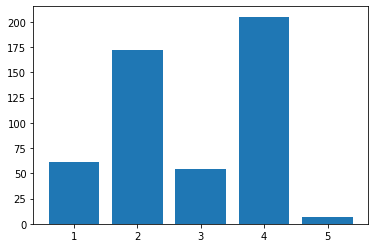

In [ ]:
for i in range(nc):
  print(i+1, "th cluster contains", len(clNames[i]), "members")

plt.bar(range(1,nc+1), [len(clNames[i]) for i in range(nc)])
plt.show()

In [ ]:
x = allVectors
#x = x[:-1]
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
allV2d = pd.DataFrame(x_reduced, columns=['PC1', 'PC2'])
allV2d['Gender'] = genders
allV2d['Cluster'] = kmeans.labels_
allV2d['Name'] = names
allV2d['Meaning'] = meanings
allV2d.head()

,PC1,PC2,Gender,Cluster,Name,Meaning
0,13.187493,-1.760166,boy,1,Aayansh,"The first Ray of light, Part of parents, Gift of God, Sun, like splendour or brightness of sun"
1,64.603282,-7.146492,girl,0,Anaya,"Without a superior, God has shown favour, Without a Superior, Look Up To God, Hebrew - God Answered, God was gracious, A variation of Aniya,"
2,37.317710,3.458507,boy,0,Avyukt,"Crystal clear or Lord Krishna or clear mind, One with a clear mind, Unconfused Being, One of the many names of Lord Krishna"
3,-12.353637,10.886611,girl,3,Aashvi,"Blessed and victorious, Little mare, One of many names of Goddess Saraswati"
4,71.602394,-3.309448,boy,0,Aarav,"Peaceful, Sound, Shout (Celebrity Parents Name: Akshay Kumar & Twinkle Khanna), Peaceful, Ray, Hope, Radiating Light, Sanskrit: ""peaceful,"" ""melodious sound"""


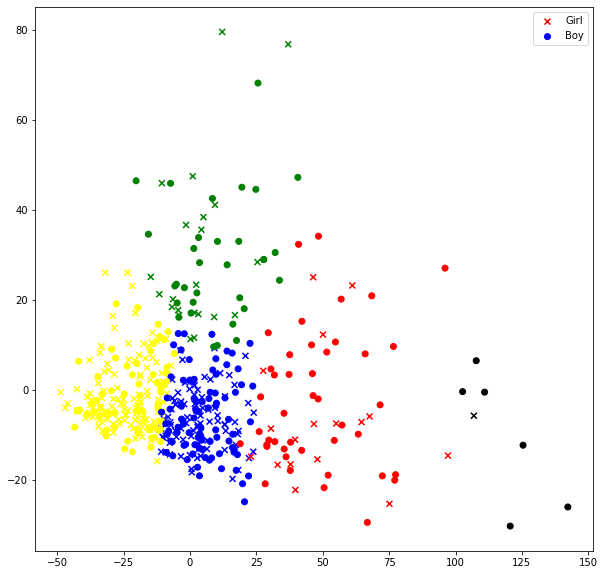

In [ ]:
colours = ['red', 'blue', 'green', 'yellow', 'black']
plt.figure(figsize=(10, 10))
plt.scatter(allV2d['PC1'][allV2d.Gender == 'girl'], allV2d['PC2'][allV2d.Gender == 'girl'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'girl']], marker='x')
plt.scatter(allV2d['PC1'][allV2d.Gender == 'boy'], allV2d['PC2'][allV2d.Gender == 'boy'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'boy']], marker='o')
plt.legend(['Girl', 'Boy'])
plt.show()

In [ ]:
for i in range(nc):
  print("\n\n\n", i+1, "th cluster:\n")
  print(allV2d.loc[allV2d.Cluster == i][['Name', 'Meaning']].head(10))




 1 th cluster:

        Name                                                                                                                                                                                       Meaning
1      Anaya                                                  Without a superior, God has shown favour, Without a Superior, Look Up To God, Hebrew - God Answered, God was gracious, A variation of Aniya,
2     Avyukt                                                                   Crystal clear or Lord Krishna or clear mind, One with a clear mind, Unconfused Being, One of the many names of Lord Krishna
4      Aarav                                 Peaceful, Sound, Shout (Celebrity Parents Name: Akshay Kumar & Twinkle Khanna), Peaceful, Ray, Hope, Radiating Light, Sanskrit: "peaceful," "melodious sound"
15    Aahana  Inner light, Immortal, Born during the day, First rise of the Sun, The name aahana has the meaning of someone like Angel,  someone sweet and charming like 

# **7 cluster**

In [ ]:
nc = 7

In [ ]:
kmeans = KMeans(n_clusters=nc, random_state=0).fit(allVectors)
#print(kmeans.labels_)
clNames = []
for i in range(nc):
  clNames.append([])
for i in range(len(allVectors)):
  #if i < 10:
    #print(clNames)
  clNames[kmeans.labels_[i]].append(i)

1 th cluster contains 112 members
2 th cluster contains 111 members
3 th cluster contains 55 members
4 th cluster contains 31 members
5 th cluster contains 48 members
6 th cluster contains 135 members
7 th cluster contains 7 members


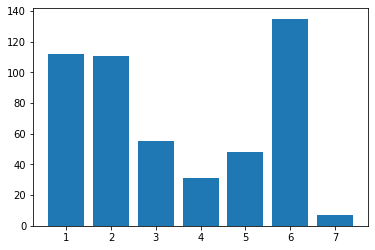

In [ ]:
for i in range(nc):
  print(i+1, "th cluster contains", len(clNames[i]), "members")

plt.bar(range(1,nc+1), [len(clNames[i]) for i in range(nc)])
plt.show()

In [ ]:
x = allVectors
#x = x[:-1]
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
allV2d = pd.DataFrame(x_reduced, columns=['PC1', 'PC2'])
allV2d['Gender'] = genders
allV2d['Cluster'] = kmeans.labels_
allV2d['Name'] = names
allV2d['Meaning'] = meanings
allV2d.head()

,PC1,PC2,Gender,Cluster,Name,Meaning
0,13.187493,-1.760166,boy,0,Aayansh,"The first Ray of light, Part of parents, Gift of God, Sun, like splendour or brightness of sun"
1,64.603282,-7.146492,girl,3,Anaya,"Without a superior, God has shown favour, Without a Superior, Look Up To God, Hebrew - God Answered, God was gracious, A variation of Aniya,"
2,37.317710,3.458507,boy,2,Avyukt,"Crystal clear or Lord Krishna or clear mind, One with a clear mind, Unconfused Being, One of the many names of Lord Krishna"
3,-12.353637,10.886611,girl,1,Aashvi,"Blessed and victorious, Little mare, One of many names of Goddess Saraswati"
4,71.602394,-3.309448,boy,3,Aarav,"Peaceful, Sound, Shout (Celebrity Parents Name: Akshay Kumar & Twinkle Khanna), Peaceful, Ray, Hope, Radiating Light, Sanskrit: ""peaceful,"" ""melodious sound"""


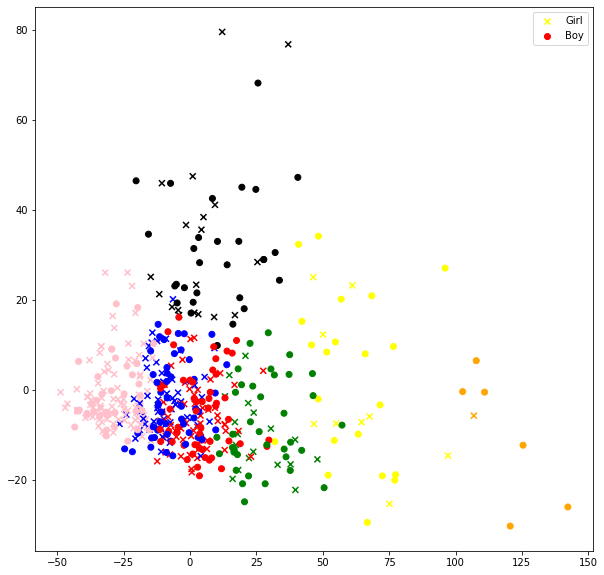

In [ ]:
colours = ['red', 'blue', 'green', 'yellow', 'black', 'pink', 'orange']
plt.figure(figsize=(10, 10))
plt.scatter(allV2d['PC1'][allV2d.Gender == 'girl'], allV2d['PC2'][allV2d.Gender == 'girl'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'girl']], marker='x')
plt.scatter(allV2d['PC1'][allV2d.Gender == 'boy'], allV2d['PC2'][allV2d.Gender == 'boy'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'boy']], marker='o')
plt.legend(['Girl', 'Boy'])
plt.show()

In [ ]:
for i in range(nc):
  print("\n\n\n", i+1, "th cluster:\n")
  print(allV2d.loc[allV2d.Cluster == i][['Name', 'Meaning']].head(10))




 1 th cluster:

       Name                                                                                                                           Meaning
0   Aayansh                                    The first Ray of light, Part of parents, Gift of God, Sun, like splendour or brightness of sun
7     Aarvi                                                               Peace, The word has a meaning of peace,  or the one who makes peace
11   Anvika                                                                                Powerful and complete, The powerful and strong one
19  Aadvika                                                  World, Earth, Unique, the word signifies the person who is Unique in all aspects
22   Aviraj                                                                            To shine as bright as the Sun, A bowman, king of Kings
23   Advait  Unique, Another name for Brahma and Vishnu, Non duality, Unique, Exclusive, Someone who has no equivalent, unequalle

# **10 cluster**

In [ ]:
nc = 10

In [ ]:
kmeans = KMeans(n_clusters=nc, random_state=0).fit(allVectors)
#print(kmeans.labels_)
clNames = []
for i in range(nc):
  clNames.append([])
for i in range(len(allVectors)):
  #if i < 10:
    #print(clNames)
  clNames[kmeans.labels_[i]].append(i)

1 th cluster contains 94 members
2 th cluster contains 7 members
3 th cluster contains 45 members
4 th cluster contains 34 members
5 th cluster contains 4 members
6 th cluster contains 25 members
7 th cluster contains 152 members
8 th cluster contains 4 members
9 th cluster contains 35 members
10 th cluster contains 99 members


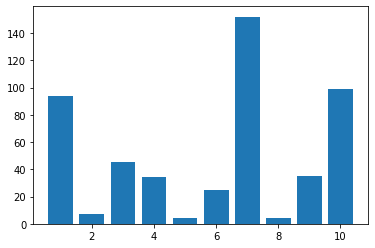

In [ ]:
for i in range(nc):
  print(i+1, "th cluster contains", len(clNames[i]), "members")

plt.bar(range(1,nc+1), [len(clNames[i]) for i in range(nc)])
plt.show()

In [ ]:
x = allVectors
#x = x[:-1]
pca = PCA(n_components=2)
x_reduced = pca.fit_transform(x)
allV2d = pd.DataFrame(x_reduced, columns=['PC1', 'PC2'])
allV2d['Gender'] = genders
allV2d['Cluster'] = kmeans.labels_
allV2d['Name'] = names
allV2d['Meaning'] = meanings
allV2d.head()

,PC1,PC2,Gender,Cluster,Name,Meaning
0,13.187493,-1.760166,boy,9,Aayansh,"The first Ray of light, Part of parents, Gift of God, Sun, like splendour or brightness of sun"
1,64.603282,-7.146492,girl,3,Anaya,"Without a superior, God has shown favour, Without a Superior, Look Up To God, Hebrew - God Answered, God was gracious, A variation of Aniya,"
2,37.317710,3.458507,boy,3,Avyukt,"Crystal clear or Lord Krishna or clear mind, One with a clear mind, Unconfused Being, One of the many names of Lord Krishna"
3,-12.353637,10.886611,girl,6,Aashvi,"Blessed and victorious, Little mare, One of many names of Goddess Saraswati"
4,71.602394,-3.309448,boy,3,Aarav,"Peaceful, Sound, Shout (Celebrity Parents Name: Akshay Kumar & Twinkle Khanna), Peaceful, Ray, Hope, Radiating Light, Sanskrit: ""peaceful,"" ""melodious sound"""


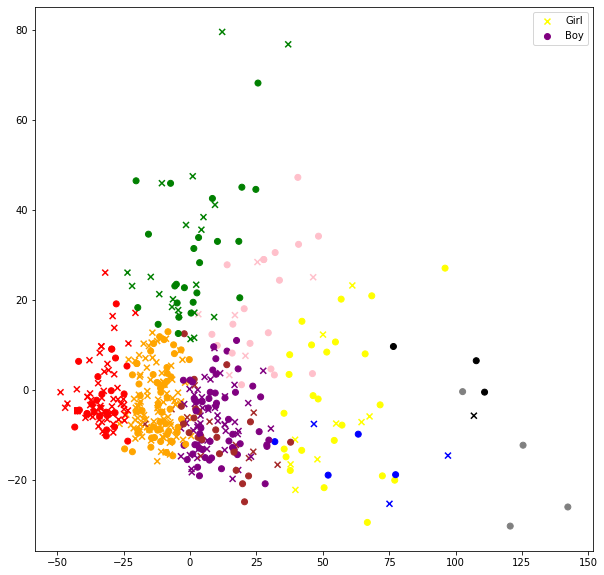

In [ ]:
colours = ['red', 'blue', 'green', 'yellow', 'black', 'pink', 'orange', 'grey', 'brown', 'purple']
plt.figure(figsize=(10, 10))
plt.scatter(allV2d['PC1'][allV2d.Gender == 'girl'], allV2d['PC2'][allV2d.Gender == 'girl'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'girl']], marker='x')
plt.scatter(allV2d['PC1'][allV2d.Gender == 'boy'], allV2d['PC2'][allV2d.Gender == 'boy'], c = [colours[i] for i in allV2d['Cluster'][allV2d.Gender == 'boy']], marker='o')
plt.legend(['Girl', 'Boy'])
plt.show()

In [ ]:
for i in range(nc):
  print("\n\n\n", i+1, "th cluster:\n")
  print(allV2d.loc[allV2d.Cluster == i][['Name', 'Meaning']].head(10))




 1 th cluster:

        Name                                                            Meaning
18    Aadvik                                                             Unique
36    Amayra                                                           Princess
43   Anaisha                                                            Special
50    Aryash            Brilliant, Brilliant, Intelligent, Knowledgeable, Noble
63     Aanvi                              One of devis names, Name of a Goddess
72    Adhvik                                                             Unique
76  Ayaanshi                                                                   
82  Avyaansh                                      Offering, Name of Lord Vishnu
83    Adrija  Of the mountain, Another name of Goddess Parvati, Name of parvati
99     Ashvi                                Blessed and victorious, Little mare



 2 th cluster:

          Name                                                                    

# **Question 2**

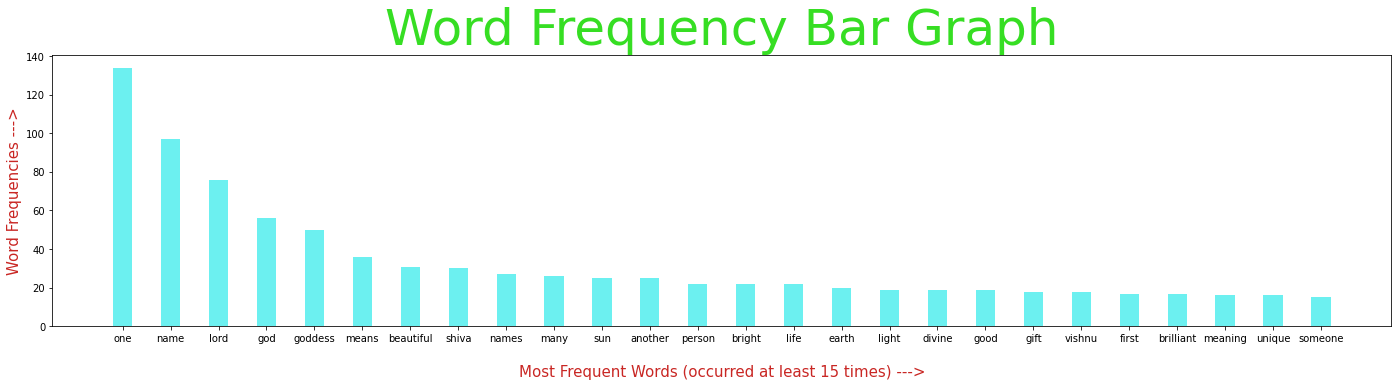

In [ ]:
freqs = FreqDist(nwordref)
x = []
y = []
for i, j in freqs.most_common():
  if j < 15:
    break
  if i not in stopwords.words('english') and i not in string.punctuation:
    #print(i, j)
    x.append(i)
    y.append(j)
plt.figure(figsize=(24, 5))
plt.bar(x, y, width=0.4, color='#6cf0f0')
plt.xlabel('\nMost Frequent Words (occurred at least 15 times) --->', fontsize=15, color='#c92724')
plt.ylabel('Word Frequencies --->', fontsize=15, color='#c92724')
plt.title('Word Frequency Bar Graph', fontsize=50, color='#36de23')
plt.show()

# **Practice**

In [ ]:
x = FreqDist(['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b'])

In [ ]:
x['a']

5

In [ ]:
x.N()

8

In [ ]:
x.B()

2

In [ ]:
x.items()

dict_items([('a', 5), ('b', 3)])

In [ ]:
x.keys()

dict_keys(['a', 'b'])

In [ ]:
x = []
for i in range(2):
  x.append([])
x[0].append(1)
print(x)

[[1], []]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

fig, ax = plt.subplots()
N = 100

scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s=1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()